In [3]:
%matplotlib notebook
from matplotlib import pyplot as plt
import os
import warnings 

warnings.filterwarnings('ignore')
from h5py import File
import numpy as np

from geoAssembler.PanelView import Calibrate
from geoAssembler.geometry import AGIPD_1MGeometry
import karabo_data as kd
from hdf5_virtualise.euxfel_vds import write_combined_file

Get a run with interesting data

In [55]:
run_dir_1 = '/gpfs/exfel/exp/SPB/201831/p900039/proc/r0273'
run_dir_2 = '/gpfs/exfel/exp/SPB/201850/p900051/proc/r0002/'
out_file_1 = os.path.join(os.environ['HOME'], 'r0273_p900039_virtual.cxi')
out_file_2 = os.path.join(os.environ['HOME'], 'r0002_p900051_virtual.cxi')
write_combined_file(run_dir_1, out_file_1)
write_combined_file(run_dir_2, out_file_2)
with File(out_file_1) as f:
    data_1 = f['/entry_1/data_1/data'][12345]
data_2 = np.load('sax_run.npz')['data']
#with File(out_file_2) as f:
#    data_2 = f['/entry_1/data_1/data'][100:500]
#warnings.resetwarnings()

INFO:hdf5_virtualise.euxfel_vds:Reading run /gpfs/exfel/exp/SPB/201831/p900039/proc/r0273 ...
/home/bergeman/.anaconda3/lib/python3.6/site-packages/h5py/_hl/dataset.py:304: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
INFO:hdf5_virtualise.euxfel_vds:Making virtual dataset for 156 trains (198425241:198425397)
INFO:hdf5_virtualise.euxfel_vds:176 frames per train
INFO:hdf5_virtualise.euxfel_vds:Pixels in one detector module: (512, 128)
INFO:hdf5_virtualise.euxfel_vds:VDS shape: (27456, 16, 512, 128)
INFO:hdf5_virtualise.euxfel_vds:Checking pulse IDs...
INFO:hdf5_virtualise.euxfel_vds:Mapped 16 chunks
INFO:hdf5_virtualise.euxfel_vds:Filled 100.00% of hyperslab with data
INFO:hdf5_virtualise.euxfel_vds:0 trains have no detector data
INFO:hdf5_virtualise.euxfel_vds:Reading run /gpfs/exfel/exp/SPB/201850/p900051/proc/r0002/ ...
INFO:hdf5_virtualise.euxfel_vds:Making virtual dataset for 37 trains (2458

Writing /home/bergeman/r0273_p900039_virtual.cxi...
Written
Writing /home/bergeman/r0002_p900051_virtual.cxi...
Written


In [92]:
#np.savez('sax_run.npz', data=data_2)
data_2 = np.load('sax_run.npz')['data']
data_1 = np.load('nonsax_run.npz')['data']

Define quad positions so that quadrants are evenly spaced

In [56]:
quad_pos = [ (-540, 610), (-540, -15), (540, -143), (540, 482)]

<IPython.core.display.Javascript object>


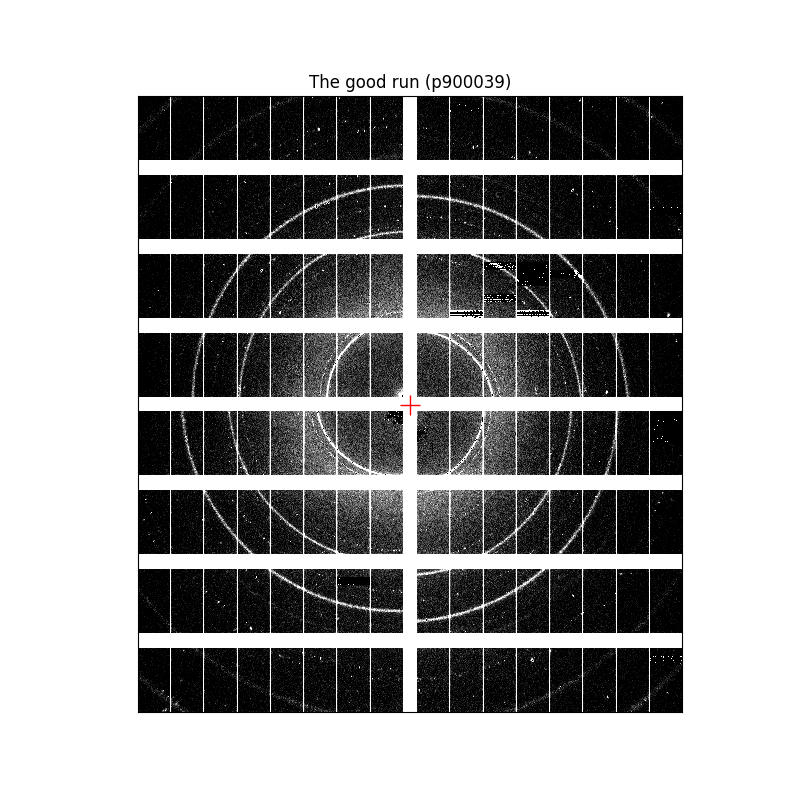

In [57]:
geom_1 = AGIPD_1MGeometry.from_quad_positions(quad_pos)
data, centre = geom_1.position_all_modules(data_1)
cy, cx = centre
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
im = ax.imshow(data, vmin=100, vmax=1500, cmap='Greys_r')
ticks = ax.set_xticks([]), ax.set_yticks([])
h1 = ax.hlines(cy, cx-20, cx+20, colors='r', linewidths=1)
h2 = ax.vlines(cx, cy-20, cy+20, colors='r', linewidths=1)
txt = ax.set_title('The good run (p900039)', fontsize=12)

<IPython.core.display.Javascript object>


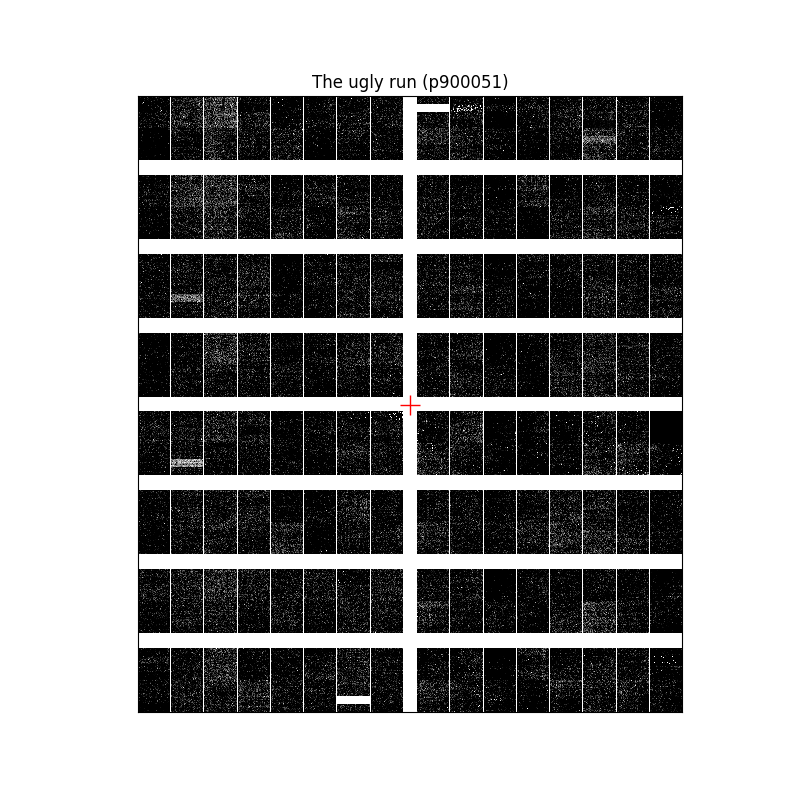

In [93]:
geom_2 = AGIPD_1MGeometry.from_quad_positions(quad_pos)
data, centre = geom_2.position_all_modules(data_2[-5])

cy, cx = centre
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
im = ax.imshow(data, vmin=1, vmax=50, cmap='Greys_r')
ticks = ax.set_xticks([]), ax.set_yticks([])
h1 = ax.hlines(cy, cx-20, cx+20, colors='r', linewidths=1)
h2 = ax.vlines(cx, cy-20, cy+20, colors='r', linewidths=1)
txt = ax.set_title('The ugly run (p900051)', fontsize=12)

<IPython.core.display.Javascript object>


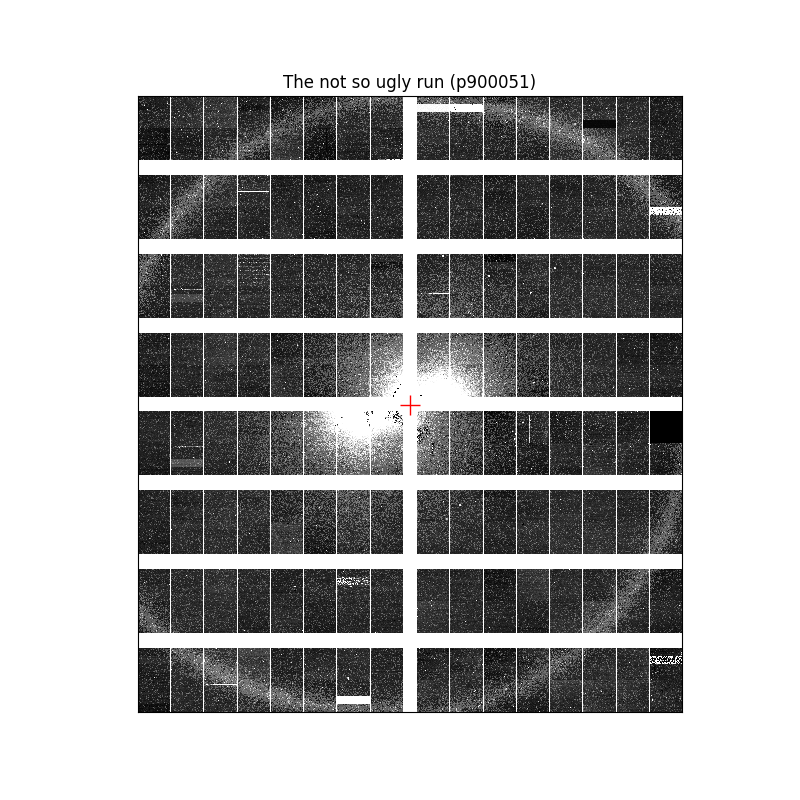

In [94]:
geom_2 = AGIPD_1MGeometry.from_quad_positions(quad_pos)
data, centre = geom_2.position_all_modules(np.nanmax(data_2, axis=0))

cy, cx = centre
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
im = ax.imshow(data, vmin=1, vmax=200, cmap='Greys_r')
ticks = ax.set_xticks([]), ax.set_yticks([])
h1 = ax.hlines(cy, cx-20, cx+20, colors='r', linewidths=1)
h2 = ax.vlines(cx, cy-20, cy+20, colors='r', linewidths=1)
txt = ax.set_title('The not so ugly run (p900051)', fontsize=12)

In [75]:
clip = Calibrate(np.nanmax(data_2, axis=0), vmin=0, vmax=200)

INFO:PanelView.py: Starting to assemble ... 
/home/bergeman/.local/lib/python3.6/site-packages/pyqtgraph/imageview/ImageView.py:588: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data = data[sl]
